In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread # for importing tiff images
import pydicom as dicom # for handling dicom files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# First Look

Anyways, let's read in the file and take a look at some of the variables.

In [2]:
images = pd.read_csv('./siim-medical-images/overview.csv')
images.head(10)
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      100 non-null    int64 
 1   Age             100 non-null    int64 
 2   Contrast        100 non-null    bool  
 3   ContrastTag     98 non-null     object
 4   raw_input_path  100 non-null    object
 5   id              100 non-null    int64 
 6   tiff_name       100 non-null    object
 7   dicom_name      100 non-null    object
dtypes: bool(1), int64(3), object(4)
memory usage: 5.7+ KB


From here, we'll import the images and stack them into a numpy array.

In [3]:
images["tiff_path"] = './siim-medical-images/tiff_images/' + images["tiff_name"]
images["dicom_path"] = './siim-medical-images/dicom_dir/' + images["dicom_name"]

# Loading in the .tiff and .dicom images

The first step to preprocess the data is to take all of the images, and stack them into one numpy array.

## .tiff

In [4]:
tiff_images = []

for path in images["tiff_path"]:
    im = imread(path)
    tiff_images.append(im)
        
tiff_images = np.array(tiff_images, dtype = 'float64')
print(tiff_images.shape)

(100, 512, 512)


Let's go ahead and take a look at the images with their respective ages, ids and Contrasts.

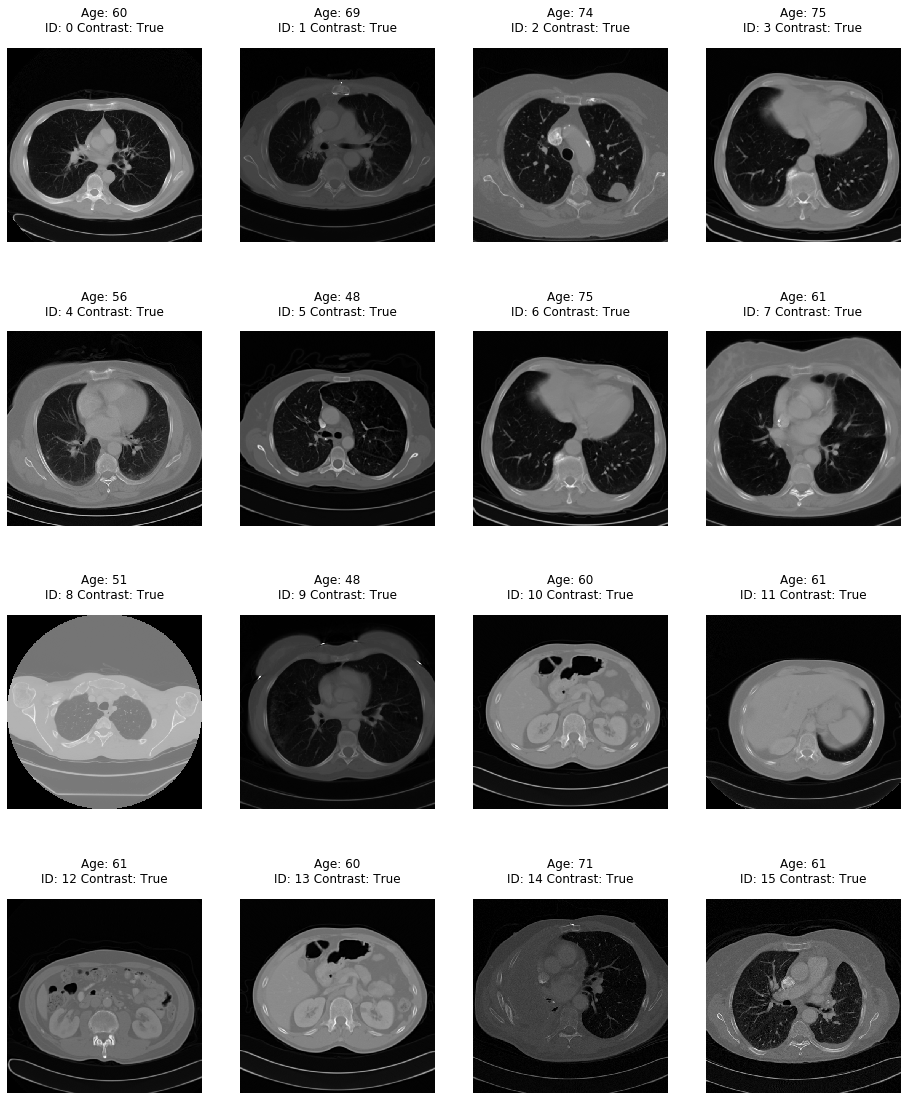

In [5]:
fig, ax = plt.subplots(4,4, figsize = (16,20))
for i,im in enumerate(tiff_images[:16]):
    ax[i//4, i%4].matshow(im, cmap = 'gray')
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title('Age: {}\nID: {} Contrast: {}'.format(images.loc[i, 'Age'], images.loc[i, 'id'], images.loc[i, 'Contrast']))
plt.show()

## .dicom

Here, we'll take the DICOM image data and out it into a numpy array.

In [6]:
dicom_images = []

for path in images["dicom_path"]:
    im = dicom.read_file(path)
    dicom_images.append(im.pixel_array)
        
dicom_images = np.array(dicom_images, dtype = 'float64')

Let's go ahead and take a look at the images with their respective ages, ids and Contrasts.

Let's take a look at the some of the histograms for the data.

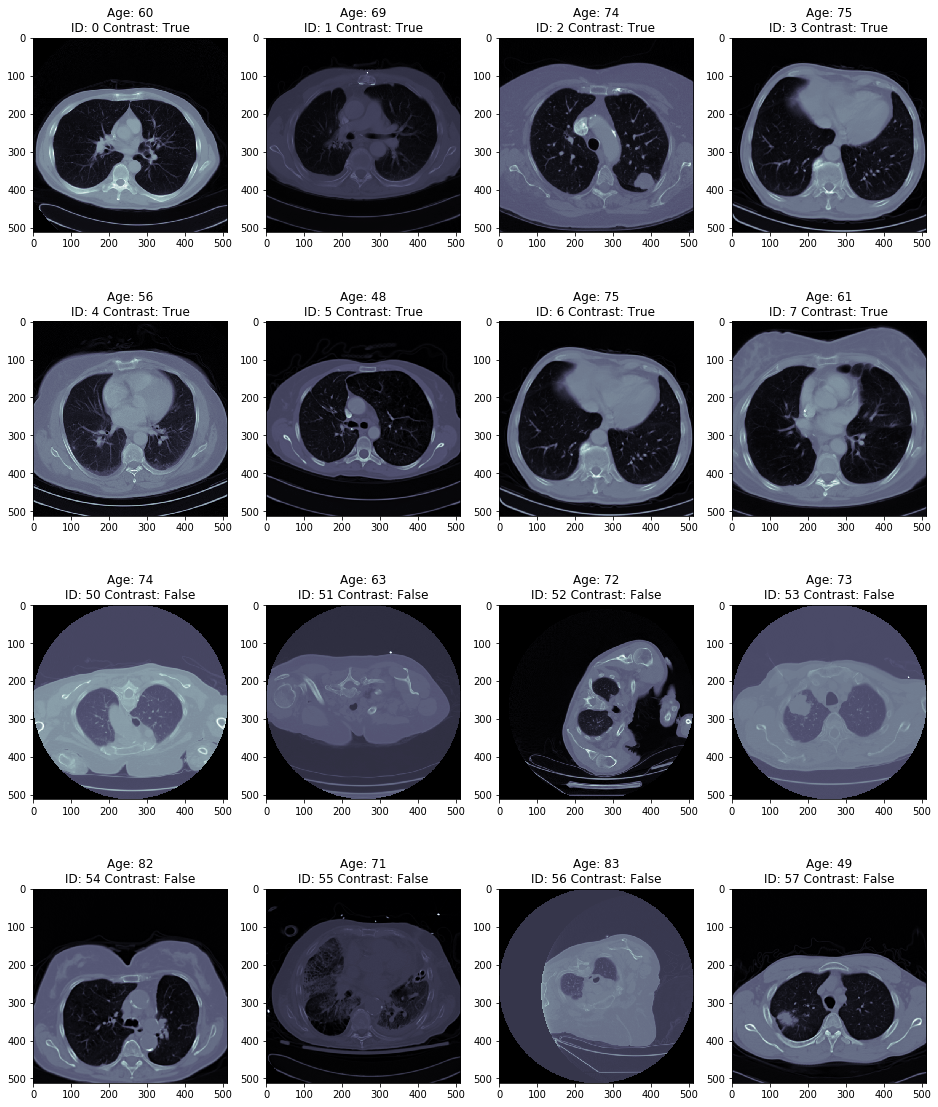

In [7]:
fig, ax = plt.subplots(4,4, figsize = (16,20))

for i,im in enumerate(dicom_images[:8]):
    ax[i//4, i%4].imshow(im, cmap = plt.cm.bone)
    ax[i//4, i%4].set_title('Age: {}\nID: {} Contrast: {}'.format(images.loc[i, 'Age'], images.loc[i, 'id'], images.loc[i, 'Contrast']))

for i,im in enumerate(dicom_images[50:58]):
    ax[(i+8)//4, (i+8)%4].imshow(im, cmap = plt.cm.bone)
    ax[(i+8)//4, (i+8)%4].set_title('Age: {}\nID: {} Contrast: {}'.format(images.loc[i+50, 'Age'], images.loc[i+50, 'id'], images.loc[i+50, 'Contrast']))
plt.show()

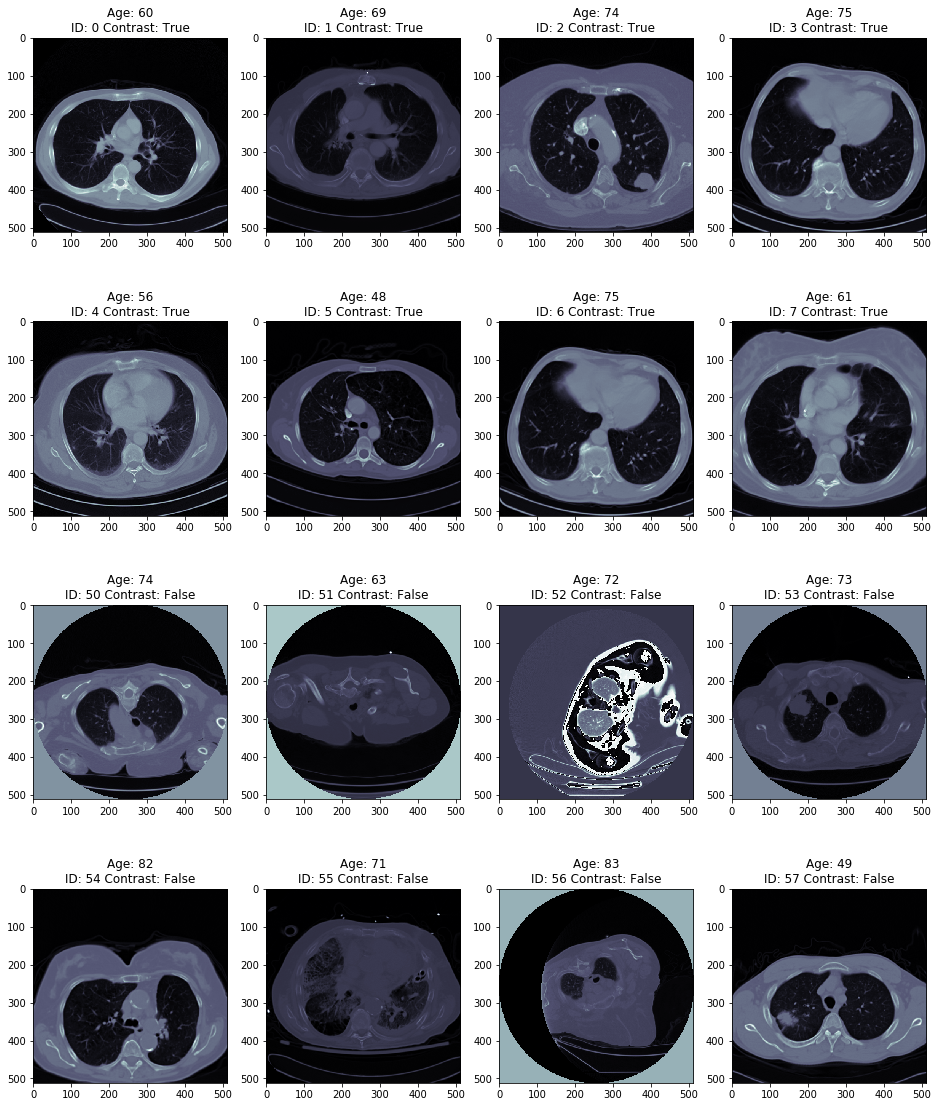

In [8]:
fig, ax = plt.subplots(4,4, figsize = (16,20))

for i,im in enumerate(dicom_images[:8]):
    im = np.uint8((im/np.amax(im))*255)
    ax[i//4, i%4].imshow(im, cmap = plt.cm.bone)
    ax[i//4, i%4].set_title('Age: {}\nID: {} Contrast: {}'.format(images.loc[i, 'Age'], images.loc[i, 'id'], images.loc[i, 'Contrast']))

for i,im in enumerate(dicom_images[50:58]):
    im = np.uint8((im/np.amax(im))*255)
    ax[(i+8)//4, (i+8)%4].imshow(im, cmap = plt.cm.bone)
    ax[(i+8)//4, (i+8)%4].set_title('Age: {}\nID: {} Contrast: {}'.format(images.loc[i+50, 'Age'], images.loc[i+50, 'id'], images.loc[i+50, 'Contrast']))
plt.show()

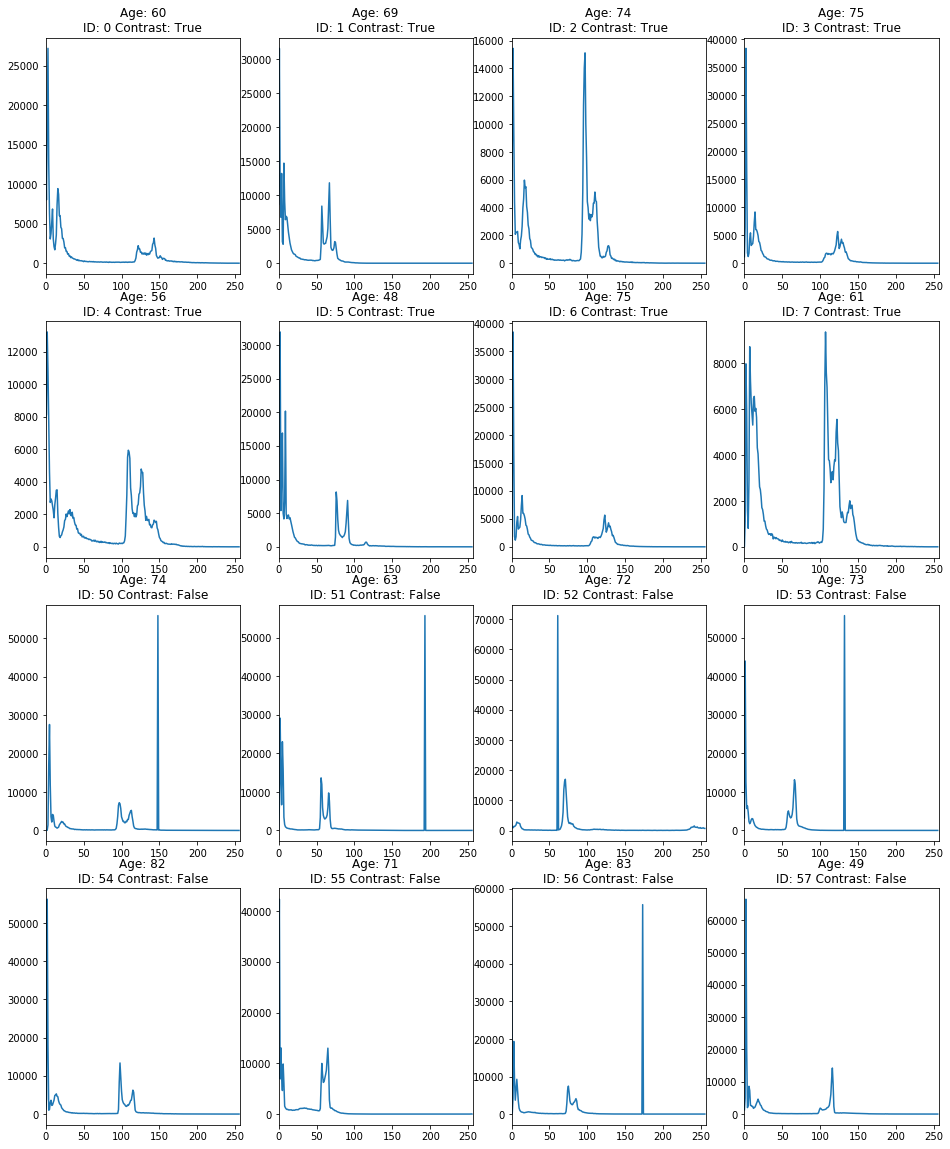

In [9]:
fig, ax = plt.subplots(4,4, figsize = (16,20))

for i,im in enumerate(dicom_images[:8]):
    im = ((im/np.amax(im))*255).astype('uint8')
    hist = cv2.calcHist([im], [0], None, [256], [0, 256])
    ax[i//4, i%4].set_xlim([0, 256])
    ax[i//4, i%4].plot(hist)
    ax[i//4, i%4].set_title('Age: {}\nID: {} Contrast: {}'.format(images.loc[i, 'Age'], images.loc[i, 'id'], images.loc[i, 'Contrast']))

for i,im in enumerate(dicom_images[50:58]):
    im = ((im/np.amax(im))*255).astype('uint8')
    hist = cv2.calcHist([im], [0], None, [256], [0, 256])
    ax[(i+8)//4, (i+8)%4].set_xlim([0, 256])
    ax[(i+8)//4, (i+8)%4].plot(hist)
    ax[(i+8)//4, (i+8)%4].set_title('Age: {}\nID: {} Contrast: {}'.format(images.loc[i+50, 'Age'], images.loc[i+50, 'id'], images.loc[i+50, 'Contrast']))
plt.show()

Let's note here that we want the ratio of True and False for the contrasts to be approximately equal, so let's make sure to preprocess the data so that the ratios of the two are approximately equal.

In [10]:
#standardize the pixel values to the range [0,1] by dividing by the max pixel value in the set
std_dicom_images = dicom_images-np.amin(dicom_images)/(np.amax(dicom_images)-np.amin(dicom_images))
#split the data into training and test data
train_data, test_data, train_labels, test_labels = train_test_split(std_dicom_images, np.array(images['Contrast']), test_size = 0.25)

#just making sure that we have an equal amount of True and False
while not(0.45 <= sum(train_labels == True)/train_labels.shape[0] <= 0.55
  and 0.45 <= sum(test_labels == True)/test_labels.shape[0] <= 0.55):
    train_data, test_data, train_labels, test_labels = train_test_split(std_dicom_images, np.array(images['Contrast']), test_size = 0.25)
     
dz,dx,dy = train_data.shape
flat_train_data = train_data.reshape((dz, dx*dy))
dz,dx,dy = test_data.shape
flat_test_data = test_data.reshape((dz, dx*dy))
print("Train Data (True): {}, Train Data (False): {} \n Test Data (True): {}, Test Data (False): {}".format(sum(train_labels == True)/train_labels.shape[0],sum(train_labels == False)/train_labels.shape[0], sum(test_labels == True)/test_labels.shape[0], sum(test_labels == False)/test_labels.shape[0])) 

Train Data (True): 0.5066666666666667, Train Data (False): 0.49333333333333335 
 Test Data (True): 0.48, Test Data (False): 0.52


# Random Forest Classifier

Let's implement a Random Forest sort of as a litmus test to see how accurate the classification is with the raw pixel data. As preparation, let's split the data into training data and testing data with the test set being 25%.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
print("Cross Validation Scores: {}".format(cross_val_score(rf, flat_train_data, train_labels, cv = 5)))
print()
rf.fit(flat_train_data, train_labels)
predictions = rf.predict(flat_test_data)
print(classification_report(test_labels,predictions))

C:\Users\Makarand\Anaconda3\envs\CV\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Makarand\Anaconda3\envs\CV\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Makarand\Anaconda3\envs\CV\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Makarand\Anaconda3\envs\CV\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Makarand\Anaconda3\envs

Cross Validation Scores: [0.9375     0.75       0.66666667 0.78571429 0.92857143]

              precision    recall  f1-score   support

       False       0.79      0.85      0.81        13
        True       0.82      0.75      0.78        12

    accuracy                           0.80        25
   macro avg       0.80      0.80      0.80        25
weighted avg       0.80      0.80      0.80        25



Now let's take a look at the predicted labels versus the actual labels next to the images to try to discern any visual patterns that the Random Forest Classifier ensemble is not doing well on. 

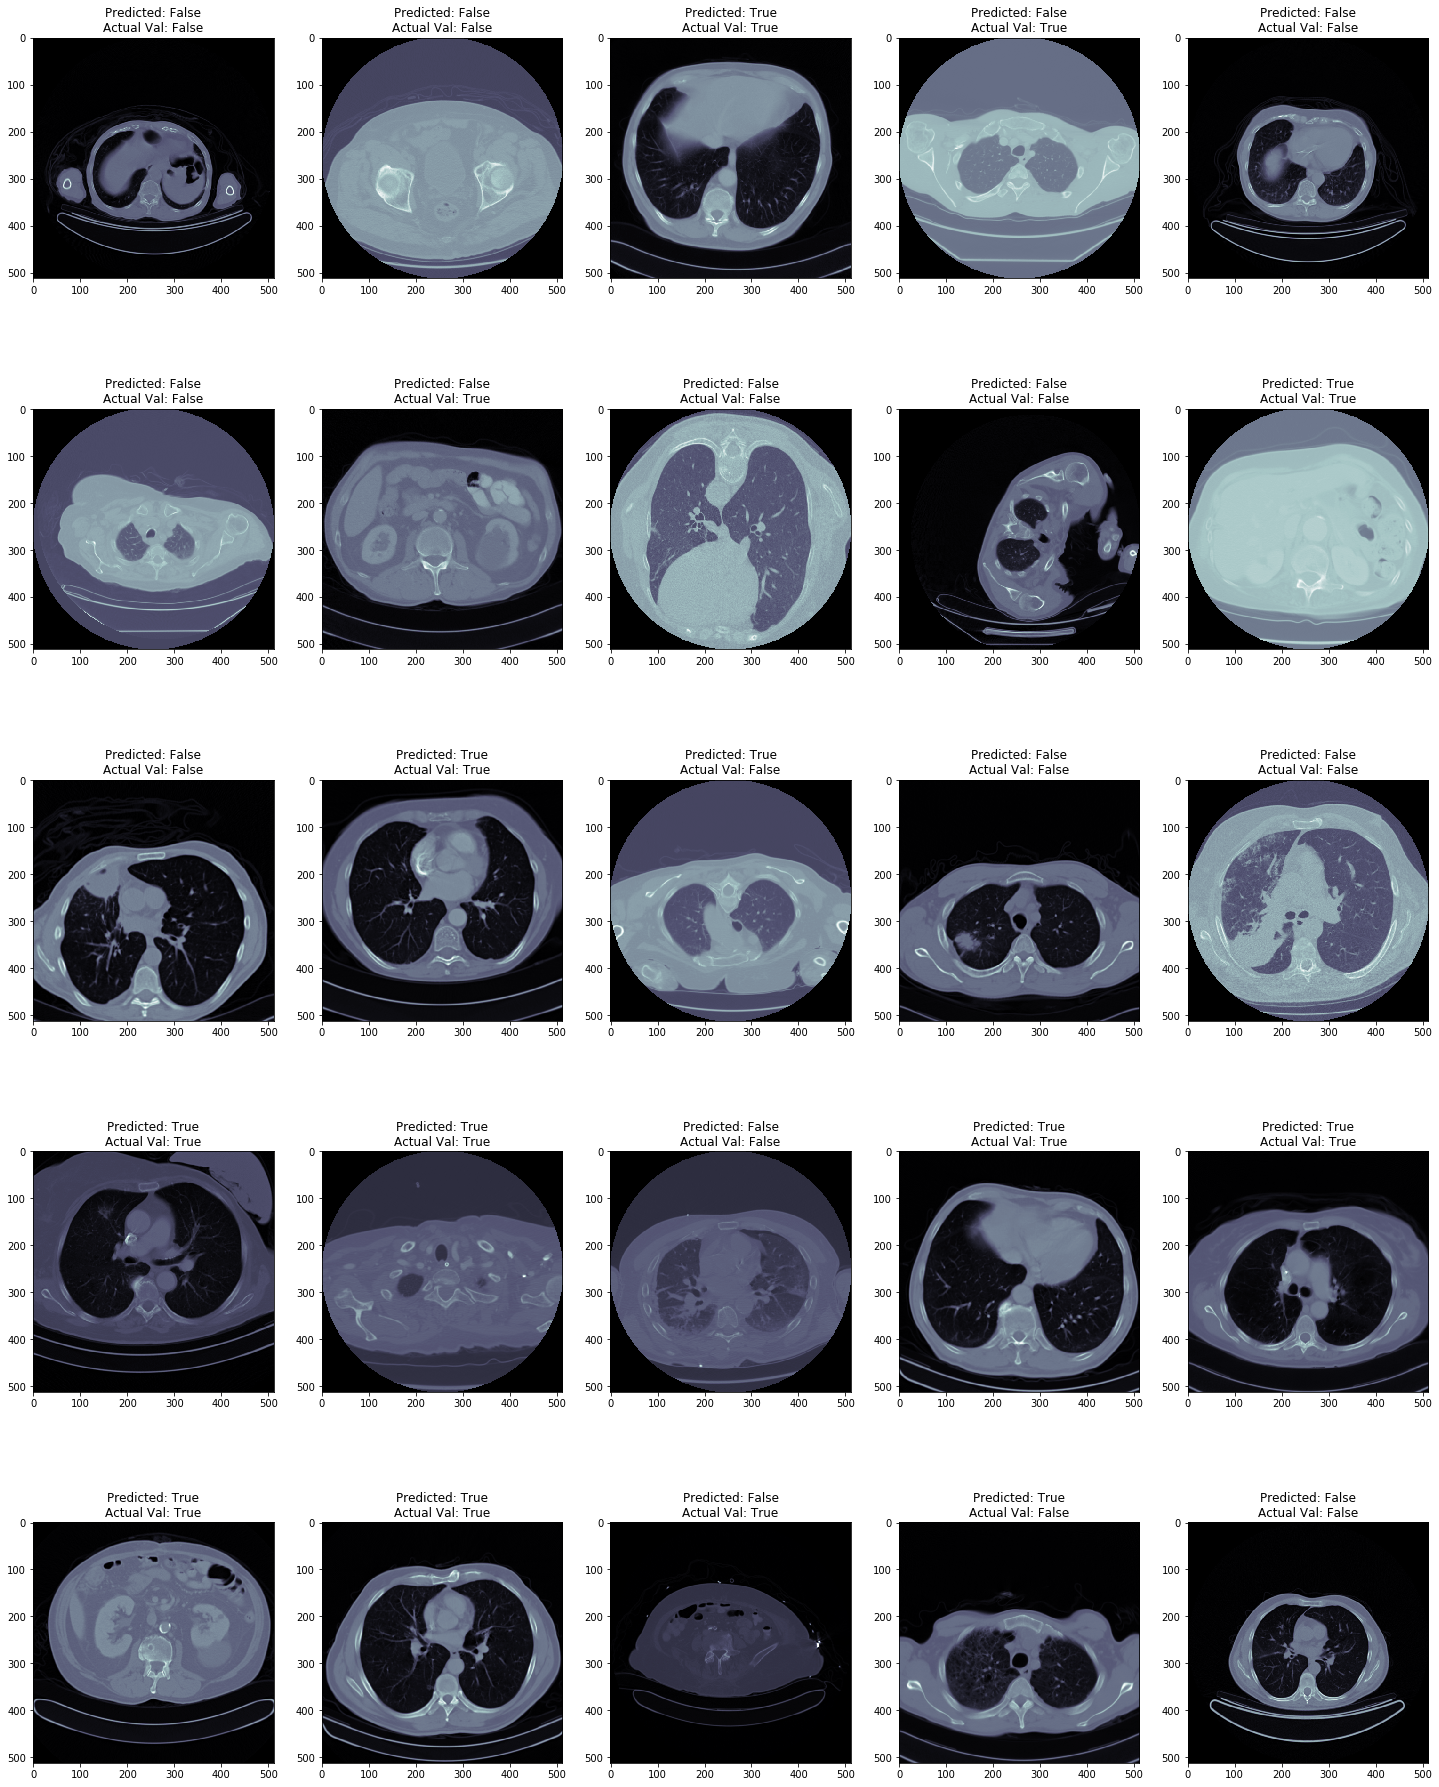

In [12]:
fig, ax = plt.subplots(5,5, figsize = (25,33))

for i, im in enumerate(test_data):
    ax[i//5,i%5].imshow(im, cmap = plt.cm.bone)
    ax[i//5,i%5].set_title("Predicted: {}\nActual Val: {}".format(predictions[i], test_labels[i]))

plt.show()

## To be continued 

* Using Different Feature Vectors as inputs for the RandomForestClassifier:
    - Shape
    - Texture
    - Color

# CNN Model

Let's test out a couple of different CNN networks on the data now!

First, we'll try KarpathyNet infrastructure and see how it goes. I'm guessing with the relative lack of data, that we will achieve significantly less accuracy than the neural network.

In [13]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [14]:
	def KarpathyNet(numChannels, imgRows, imgCols, numClasses, dropout=False):
		# initialize the model
		model = Sequential()
		inputShape = (imgRows, imgCols, numChannels)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (numChannels, imgRows, imgCols)

		# define the first set of CONV => RELU => POOL layers
		model.add(Conv2D(16, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		#if dropout:
		#	model.add(Dropout(0.25))

		# define the second set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		#if dropout:
		#	model.add(Dropout(0.25))

		# define the third set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		if dropout:
			model.add(Dropout(0.25))

		# define the soft-max classifier
		model.add(Flatten())
		model.add(Dense(numClasses))
		model.add(Activation("softmax"))

		# return the network architecture
		return model

In [15]:
ohenc_train_labels = to_categorical(train_labels)
ohenc_test_labels = to_categorical(test_labels)
train_data = train_data.reshape((75, 512, 512, 1))
test_data = test_data.reshape((25, 512, 512, 1))

(rows, cols) = dicom_images.shape[1:]
model = KarpathyNet(1,rows,cols,2, dropout = True)
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr = 0.001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
model.fit(train_data, ohenc_train_labels, batch_size=32, epochs=20, verbose=1)

Train on 75 samples
Epoch 1/20
75/75 [==============================] - 5s 61ms/sample - loss: 792.1720 - accuracy: 0.4800
Epoch 2/20
75/75 [==============================] - 0s 4ms/sample - loss: 244.1635 - accuracy: 0.6267
Epoch 3/20
75/75 [==============================] - 0s 4ms/sample - loss: 74.3766 - accuracy: 0.7200
Epoch 4/20
75/75 [==============================] - 0s 4ms/sample - loss: 5.6936 - accuracy: 0.7600
Epoch 5/20
75/75 [==============================] - 0s 4ms/sample - loss: 7.6720 - accuracy: 0.6800
Epoch 6/20
75/75 [==============================] - 0s 4ms/sample - loss: 2.9730 - accuracy: 0.7733
Epoch 7/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.2195 - accuracy: 0.8800
Epoch 8/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.3304 - accuracy: 0.8933
Epoch 9/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.1892 - accuracy: 0.9200
Epoch 10/20
75/75 [==============================] - 0s 4ms/sample - loss:

Now to test the model on the remaining parameters.

In [16]:
(loss, accuracy) = model.evaluate(test_data, ohenc_test_labels, batch_size=32, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

25/25 [==============================] - 0s 20ms/sample - loss: 3.0112 - accuracy: 0.6400
[INFO] accuracy: 64.00%


## To be continued:

- Different CNN architectures using more of the dataset than what's avaialable on Kaggle.

In [17]:
	def AlexNet(numChannels, imgRows, imgCols, numClasses, dropout = False):
		model = Sequential()
		inputShape = (imgRows, imgCols, numChannels)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (numChannels, imgRows, imgCols)
        
        # 1st Convolutional Layer
		model.add(Conv2D(filters=96, input_shape=inputShape, kernel_size=(11,11), strides=(4,4), padding="valid"))
		model.add(Activation("relu"))
        # Max Pooling
		model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

        # 2nd Convolutional Layer
		model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding="valid"))
		model.add(Activation("relu"))
        # Max Pooling
		model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

        # 3rd Convolutional Layer
		model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
		model.add(Activation("relu"))

        # 4th Convolutional Layer
		model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
		model.add(Activation("relu"))

        # 5th Convolutional Layer
		model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="valid"))
		model.add(Activation("relu"))
        # Max Pooling
		model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

        # Passing it to a Fully Connected layer
		model.add(Flatten())
        # 1st Fully Connected Layer
		model.add(Dense(4096))
		model.add(Activation("relu"))
        # Add Dropout to prevent overfitting
		if dropout == True:
			model.add(Dropout(0.4))

        # 2nd Fully Connected Layer
		model.add(Dense(4096))
		model.add(Activation("relu"))
        # Add Dropout
		if dropout == True:
			model.add(Dropout(0.4))

        # 3rd Fully Connected Layer
		model.add(Dense(1000))
		model.add(Activation("relu"))
        # Add Dropout
		if dropout == True:
			model.add(Dropout(0.4))

        # Output Layer
		model.add(Dense(numClasses))
		model.add(Activation("softmax"))
        
		return model

In [18]:
(rows, cols) = dicom_images.shape[1:]
model = AlexNet(1,rows,cols,2)
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr = 0.0001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
model.fit(train_data, ohenc_train_labels, batch_size=32, epochs=20, verbose=1)

Train on 75 samples
Epoch 1/20
75/75 [==============================] - 5s 73ms/sample - loss: 189.4378 - accuracy: 0.4800
Epoch 2/20
75/75 [==============================] - 0s 4ms/sample - loss: 40.6896 - accuracy: 0.4533
Epoch 3/20
75/75 [==============================] - 0s 4ms/sample - loss: 2.6909 - accuracy: 0.4667
Epoch 4/20
75/75 [==============================] - 0s 4ms/sample - loss: 1.3020 - accuracy: 0.6133
Epoch 5/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.7471 - accuracy: 0.6000
Epoch 6/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.5096 - accuracy: 0.7467
Epoch 7/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.4483 - accuracy: 0.8267
Epoch 8/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.3621 - accuracy: 0.8400
Epoch 9/20
75/75 [==============================] - 0s 4ms/sample - loss: 0.3069 - accuracy: 0.8533
Epoch 10/20
75/75 [==============================] - 0s 4ms/sample - loss: 0

In [19]:
(loss, accuracy) = model.evaluate(test_data, ohenc_test_labels, batch_size=32, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

25/25 [==============================] - 1s 52ms/sample - loss: 0.4698 - accuracy: 0.8800
[INFO] accuracy: 88.00%


In [20]:
from tensorflow.keras.applications import ResNet50

def ResNet(numChannels, imgRows, imgCols, numClasses):

    model = Sequential()

    # 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
    # NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
    model.add(ResNet50(include_top = False, pooling = 'avg', weights = resnet_weights_path))

    # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
    model.add(Dense(numClasses, activation = 'softmax'))

    # Say not to train first layer (ResNet) model as it is already trained
    model.layers[0].trainable = False